In [4]:
import os, sys
from pathlib import Path
import pandas as pd
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")

ROOT = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
AUDIO_DIR = ROOT / "audios-wav"
DATASET_CSV = ROOT / "data" / "cleaned_dataset.csv"

print("ROOT:", ROOT)
print("AUDIO_DIR exists:", AUDIO_DIR.exists())
print("DATASET_CSV exists:", DATASET_CSV.exists())


PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA version: 11.8
Number of GPUs: 1
Current GPU: 0
GPU name: NVIDIA GeForce RTX 2060
ROOT: C:\Users\AboMajed\audio-seg\Audio-AI
AUDIO_DIR exists: True
DATASET_CSV exists: True


In [5]:
df = pd.read_csv(DATASET_CSV)
print("Total rows:", len(df))
display(df.head())


Total rows: 60


,audio,speaker_count,language
0,../audios-wav/audios-ar/3_speakers_ar/three_sp...,3 Speakers,ar
1,../audios-wav/audios-en/2_speakers_en/two_spea...,2 Speakers,en
2,../audios-wav/audios-ar/2_speakers_ar/two_spea...,2 Speakers,ar
3,../audios-wav/audios-ar/3_speakers_ar/three_sp...,3 Speakers,ar
4,../audios-wav/audios-en/2_speakers_en/two_spea...,2 Speakers,en


In [6]:
from dotenv import load_dotenv
import torch
load_dotenv()


from pathlib import Path
import os
from pyannote.audio import Pipeline as PNA_Pipeline

row = df.iloc[0]
audio_path = Path(row["audio"]).resolve()
print(f"Testing: {audio_path.name} | language={row['language']} | true={row['speaker_count']}")

token = os.environ.get("HUGGINGFACE_TOKEN")
pipe = PNA_Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",
    use_auth_token=token
)
if torch.cuda.is_available():
    pipe = pipe.to(torch.device("cuda"))
    print("✓ Pipeline moved to GPU")
else:
    print("⚠ Pipeline using CPU")
diarization = pipe(str(audio_path))

speakers = {spk for _, _, spk in diarization.itertracks(yield_label=True)}
print("Predicted speaker count:", len(speakers))


Testing: three_speakers7_ar.wav | language=ar | true=3 Speakers
✓ Pipeline moved to GPU


c:\Users\AboMajed\audio-seg\Audio-AI\.venv\lib\site-packages\pyannote\audio\utils\reproducibility.py:74: ReproducibilityWarning: TensorFloat-32 (TF32) has been disabled as it might lead to reproducibility issues and lower accuracy.
It can be re-enabled by calling
   >>> import torch
   >>> torch.backends.cuda.matmul.allow_tf32 = True
   >>> torch.backends.cudnn.allow_tf32 = True
See https://github.com/pyannote/pyannote-audio/issues/1370 for more details.

  warnings.warn(
c:\Users\AboMajed\audio-seg\Audio-AI\.venv\lib\site-packages\pyannote\audio\models\blocks\pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  std = sequences.std(dim=-1, correction=1)


Predicted speaker count: 3


In [7]:
from dotenv import load_dotenv
load_dotenv()

import os
from pyannote.audio import Pipeline as PNA_Pipeline

# (Re)create the global pipeline only if missing
if 'pipe' not in globals() or pipe is None:
    token = os.environ.get("HUGGINGFACE_TOKEN")
    if not token:
        raise RuntimeError("HUGGINGFACE_TOKEN not found. Put it in .env and rerun load_dotenv().")
    pipe = PNA_Pipeline.from_pretrained(
        "pyannote/speaker-diarization-3.1",
        use_auth_token=token
    )
print("PyAnnote pipeline ready:", type(pipe))


PyAnnote pipeline ready: <class 'pyannote.audio.pipelines.speaker_diarization.SpeakerDiarization'>


In [8]:
from pathlib import Path
import time, re
import numpy as np
import pandas as pd

# ensure results dir exists
RESULTS_DIR = Path.cwd().parents[0] / "results" if Path.cwd().name == "notebooks" else Path.cwd() / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV = RESULTS_DIR / "pyannote_predictions.csv"

# reuse the already-loaded pipeline `pipe`
assert 'pipe' in globals(), "Run the PyAnnote smoke-test cell first to create `pipe`."

def true_count(s):
    # extract the first integer from "speaker_count" (e.g., '3 Speakers' -> 3)
    m = re.search(r"\d+", str(s))
    return int(m.group()) if m else np.nan

rows = []
failures = 0

for i, r in df.iterrows():
    audio_path = Path(r["audio"]).resolve()
    t0 = time.time()
    try:
        dia = pipe(str(audio_path))
        speakers = {spk for _, _, spk in dia.itertracks(yield_label=True)}
        pred = len(speakers)
    except Exception as e:
        pred = np.nan
        failures += 1
    dt = time.time() - t0

    rows.append({
        "audio": str(audio_path),
        "language": r["language"],               # untouched
        "true_speakers": true_count(r["speaker_count"]),
        "pred_speakers": pred,
        "runtime_sec": dt,
    })

pred_df = pd.DataFrame(rows)
pred_df.to_csv(OUT_CSV, index=False)

print(f"Saved: {OUT_CSV}")
print(f"Total rows: {len(pred_df)} | Failures: {failures}")
display(pred_df.head(10))


Saved: c:\Users\AboMajed\audio-seg\Audio-AI\results\pyannote_predictions.csv
Total rows: 60 | Failures: 0


,audio,language,true_speakers,pred_speakers,runtime_sec
0,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,ar,3,3,16.593641
1,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,2,2,13.713065
2,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,ar,2,2,9.936236
3,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,ar,3,3,11.928650
4,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,2,3,13.806100
5,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,1,1,8.702929
6,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,2,2,15.398440
7,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,1,1,9.845201
8,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,2,2,17.384885
9,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,2,2,9.708357


=== PyAnnote Evaluation ===
Accuracy         : 86.67%
Precision (macro): 67.51%
Recall (macro)   : 65.00%
F1-score (macro) : 66.06%

Detailed per-class report:
              precision    recall  f1-score   support

           1      1.000     0.950     0.974        20
           2      0.818     0.900     0.857        20
           3      0.882     0.750     0.811        20
           4      0.000     0.000     0.000         0

    accuracy                          0.867        60
   macro avg      0.675     0.650     0.661        60
weighted avg      0.900     0.867     0.881        60



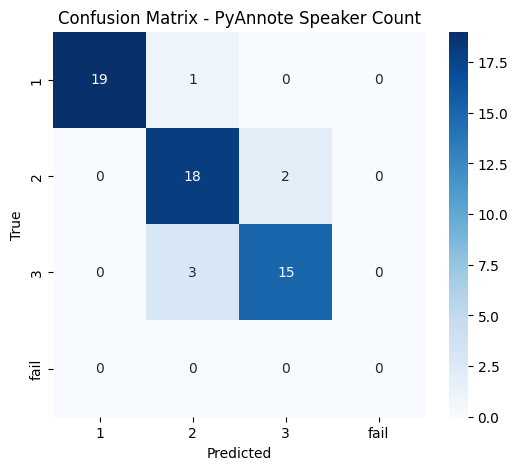

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from pathlib import Path

# point to the saved predictions
RESULTS_DIR = (Path.cwd().parents[0] / "results") if Path.cwd().name == "notebooks" else (Path.cwd() / "results")
OUT_CSV = RESULTS_DIR / "pyannote_predictions.csv"

# reload predictions
pred_df = pd.read_csv(OUT_CSV)

y_true = pred_df["true_speakers"].astype(int)
y_pred = pred_df["pred_speakers"].fillna(-1).astype(int)  # -1 = failure

# --- Metrics ---
acc = accuracy_score(y_true, y_pred)
prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
recall_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)

print("=== PyAnnote Evaluation ===")
print(f"Accuracy         : {acc:.2%}")
print(f"Precision (macro): {prec_macro:.2%}")
print(f"Recall (macro)   : {recall_macro:.2%}")
print(f"F1-score (macro) : {f1_macro:.2%}\n")

print("Detailed per-class report:")
print(classification_report(y_true, y_pred, digits=3, zero_division=0))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred, labels=[1,2,3,-1])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[1,2,3,"fail"], yticklabels=[1,2,3,"fail"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - PyAnnote Speaker Count")
plt.show()



=== Language: AR ===
              precision    recall  f1-score   support

           1      1.000     0.900     0.947        10
           2      0.769     1.000     0.870        10
           3      1.000     0.700     0.824        10
           4      0.000     0.000     0.000         0

    accuracy                          0.867        30
   macro avg      0.692     0.650     0.660        30
weighted avg      0.923     0.867     0.880        30


=== Language: EN ===
              precision    recall  f1-score   support

           1      1.000     1.000     1.000        10
           2      0.889     0.800     0.842        10
           3      0.800     0.800     0.800        10
           4      0.000     0.000     0.000         0

    accuracy                          0.867        30
   macro avg      0.672     0.650     0.661        30
weighted avg      0.896     0.867     0.881        30



/var/folders/8b/4_8wc57j36qc08pv4nrd3bhm0000gn/T/ipykernel_3640/2277707468.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_lang = pred_df.groupby("language").apply(


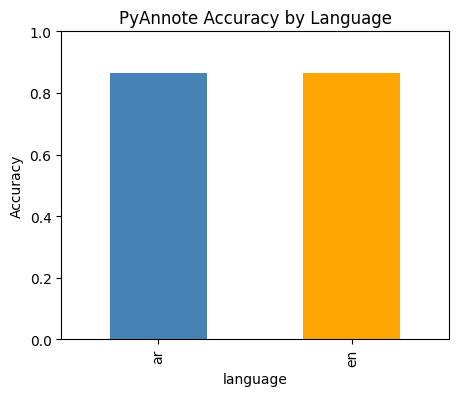

In [3]:
from sklearn.metrics import classification_report

# Group by language and print per-class metrics
for lang, sub in pred_df.groupby("language"):
    print(f"\n=== Language: {lang.upper()} ===")
    y_true = sub["true_speakers"].astype(int)
    y_pred = sub["pred_speakers"].fillna(-1).astype(int)
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))

# Plot accuracy by language
acc_by_lang = pred_df.groupby("language").apply(
    lambda d: (d["true_speakers"] == d["pred_speakers"]).mean()
)

plt.figure(figsize=(5,4))
acc_by_lang.plot(kind="bar", color=["steelblue","orange"])
plt.ylabel("Accuracy")
plt.title("PyAnnote Accuracy by Language")
plt.ylim(0,1)
plt.show()
